<a href="https://colab.research.google.com/github/Scott-Huston/DS-Unit-2-Regression-Classification/blob/master/DS6_lesson_regression_classification_3_lecture_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:
- [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/), version >= 2.0
- [Plotly](https://plot.ly/python/getting-started/), version >= 4.0

```
conda install -c conda-forge category_encoders plotly
```

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
   7283efe..9c51072  master     -> origin/master
Updating 7283efe..9c51072
Fast-forward
 module3/lesson_regression_classification_3.ipynb | 564 +++++++++++++++++++++++
 1 file changed, 564 insertions(+)
 create mode 100644 module3/lesson_regression_classification_3.ipynb


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

# Let's start with example solutions for yesterday's assignment!

First, load data & remove outliers:

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

## Do train/test split
- Use data from April & May 2016 to train
- Use data from June 2016 to test

In [0]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].describe()

count                   48817
unique                  48148
top       2016-05-14 01:11:03
freq                        3
first     2016-04-01 22:12:41
last      2016-06-29 21:41:47
Name: created, dtype: object

In [0]:
# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [0]:
# There are many ways to do train/test split based on date.
# Here's one way:
train = df[df.created.dt.month < 6]
test  = df[df.created.dt.month == 6]
train.shape, test.shape

((31844, 34), (16973, 34))

In [0]:
# Here's another way
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test  = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [0]:
# Here's another way
df = df.set_index('created')
train = df[:'2016-05'].reset_index()
test  = df['2016-06':].reset_index()
df = df.reset_index()
train.shape, test.shape

((31844, 34), (16973, 34))

## Location, Location, Location?

In [0]:
# Look at relationship between location & price
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='price')

In [0]:
# Cluster the locations
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_jobs=-1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
px.scatter(train, x='longitude', y='latitude', color='cluster')

In [0]:
train.groupby('bedrooms').price.mean()

bedrooms
0    2480.870706
1    3057.281467
2    3787.781992
3    4974.523553
4    5922.475355
5    8177.637681
6    8228.863636
7    6923.000000
Name: price, dtype: float64

In [0]:
train.groupby('cluster').price.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,721.0,2313.020804,805.724926,1375.0,1800.0,2100.0,2600.00,11000.0
1,4820.0,3753.086722,1754.175206,1450.0,2700.0,3295.0,4250.00,15500.0
2,6059.0,4048.907906,1707.886860,1500.0,2895.0,3625.0,4750.00,15500.0
3,2583.0,3645.883856,1947.977861,1395.0,2500.0,3100.0,4010.00,15500.0
4,1456.0,2216.313187,664.088323,1375.0,1700.0,2000.0,2506.25,5000.0
5,525.0,2038.266667,512.760734,1375.0,1695.0,1900.0,2250.00,4350.0
6,3364.0,3931.534483,1692.508585,1450.0,2850.0,3450.0,4450.00,15000.0
7,4898.0,3740.444875,1514.313884,1550.0,2710.0,3350.0,4395.00,15000.0
8,1430.0,2770.948252,939.594063,1375.0,2196.0,2600.0,3147.00,14500.0


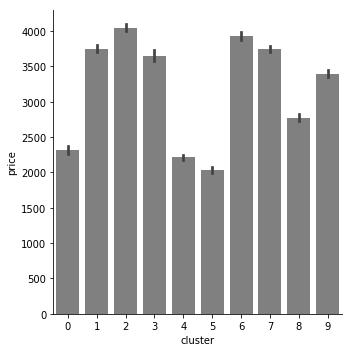

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.catplot(x='cluster', y='price', data=train, kind='bar', color='grey');

## Exploratory visualization for predictive modeling

Visualize the relationships between feature(s) and target.

_Recommendations:_

Do this with your training set, after splitting your data. 

Try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

Try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features.

Seaborn is nice because it includes confidence intervals to visualize uncertainty.

In [0]:
train['bathrooms'].value_counts()

1.0     25507
2.0      5001
3.0       455
1.5       411
0.0       191
2.5       181
4.0        62
3.5        28
4.5         5
5.0         2
10.0        1
Name: bathrooms, dtype: int64

In [0]:
train.groupby('bathrooms').price.describe()

,count,mean,std,min,25%,50%,75%,max
bathrooms,,,,,,,,
0.0,191.0,3373.109948,2053.518599,1466.0,2453.50,2750.0,3372.50,15000.0
1.0,25507.0,3035.404281,975.887086,1375.0,2390.00,2900.0,3500.00,15500.0
1.5,411.0,4181.374696,1297.611957,1850.0,3200.00,4105.0,4825.00,12000.0
2.0,5001.0,5442.525295,1789.672550,1550.0,4400.00,5195.0,6200.00,15500.0
2.5,181.0,8292.370166,2973.460945,2200.0,6295.00,7845.0,10000.00,15500.0
3.0,455.0,9518.182418,3214.857649,1650.0,6997.50,9635.0,12000.00,15000.0
3.5,28.0,11928.892857,2750.821875,7500.0,8925.00,12700.0,14248.75,15000.0
4.0,62.0,9673.354839,2910.605644,1503.0,8921.25,10000.0,12000.00,15500.0
4.5,5.0,11910.000000,5550.045045,2050.0,13500.00,14000.0,15000.00,15000.0


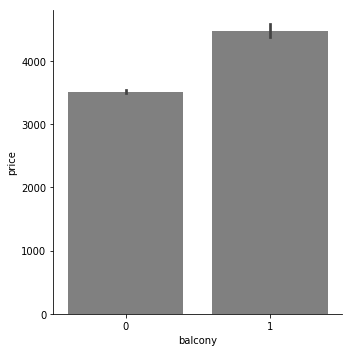

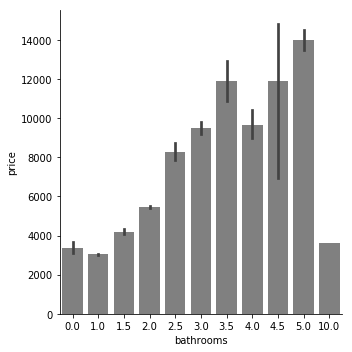

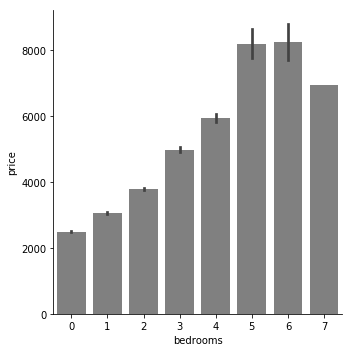

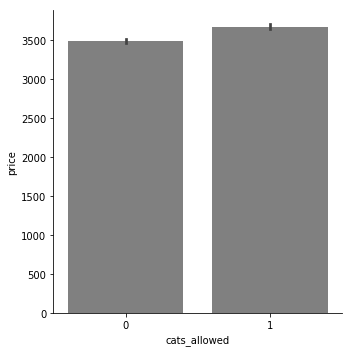

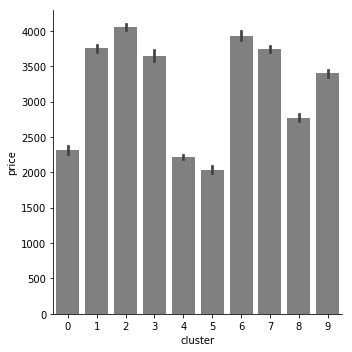

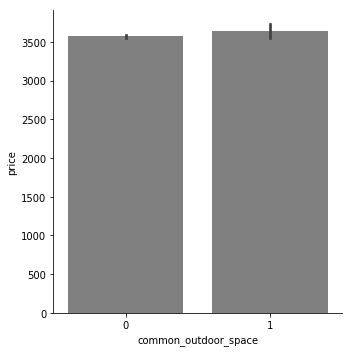

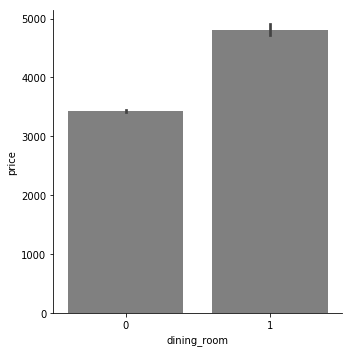

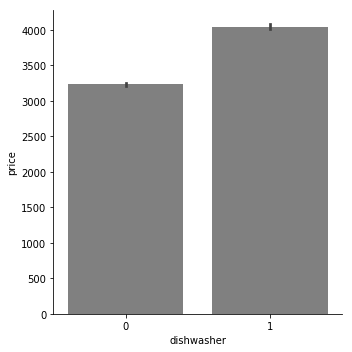

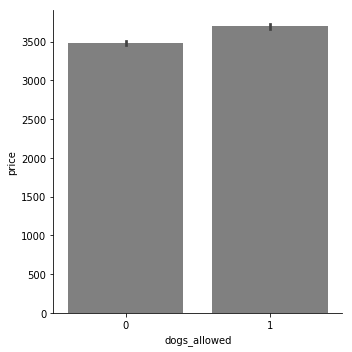

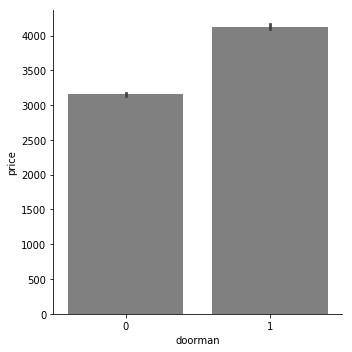

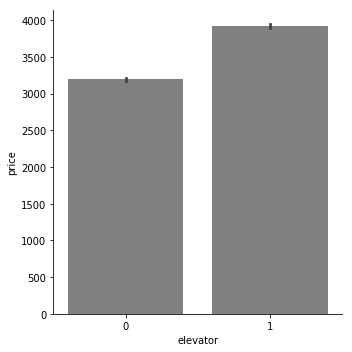

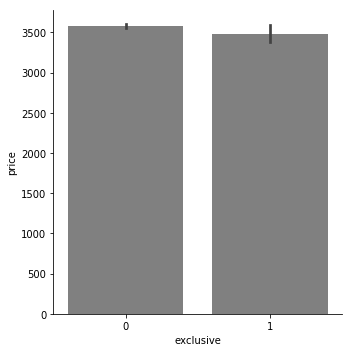

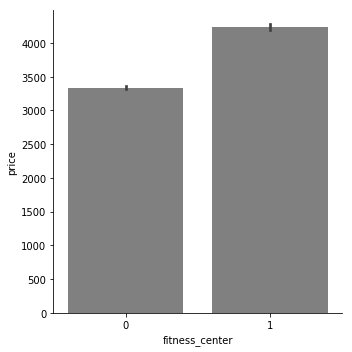

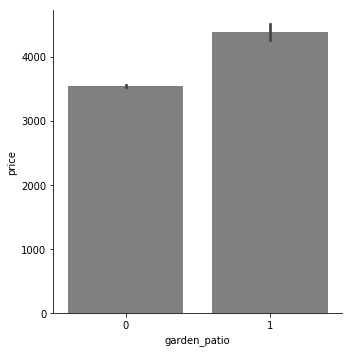

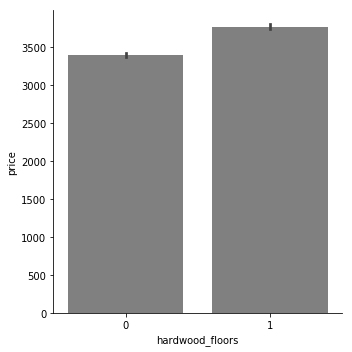

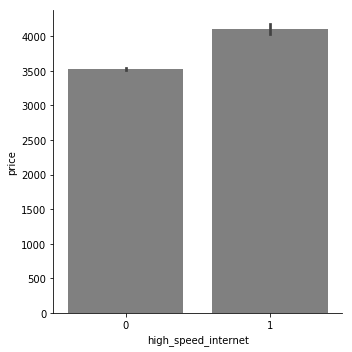

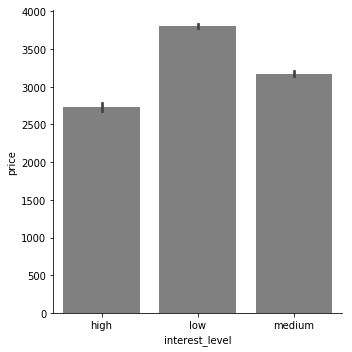

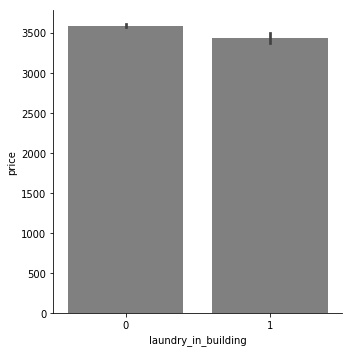

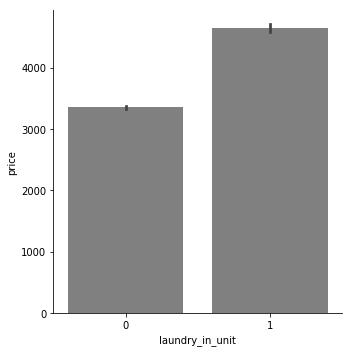

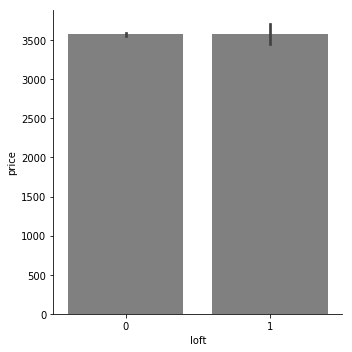

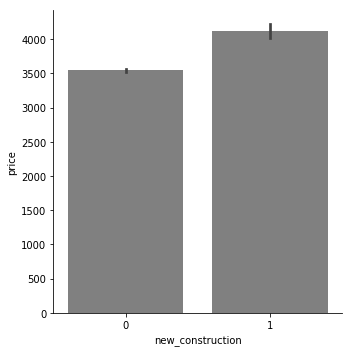

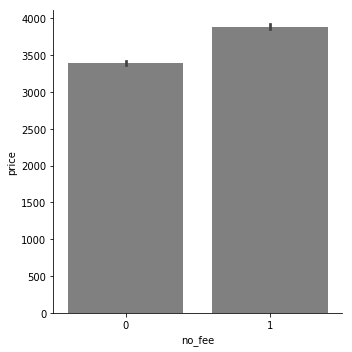

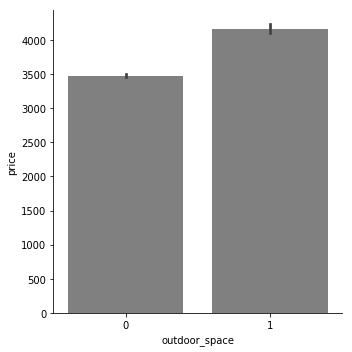

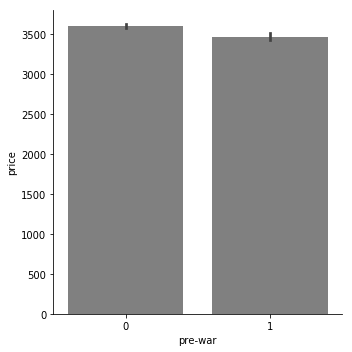

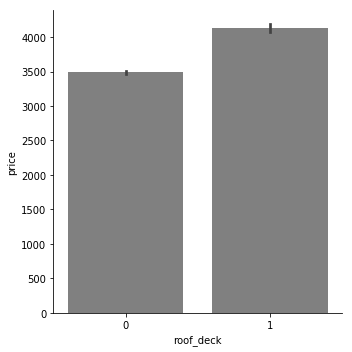

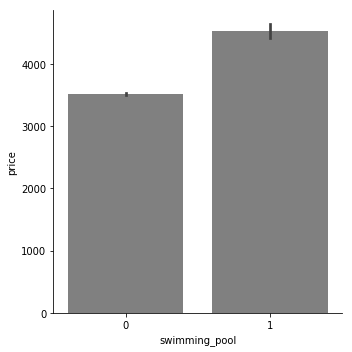

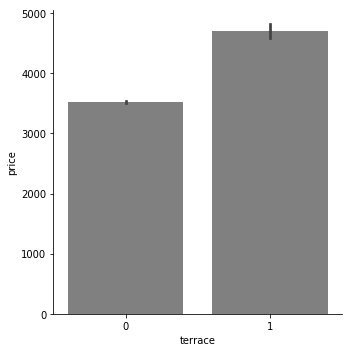

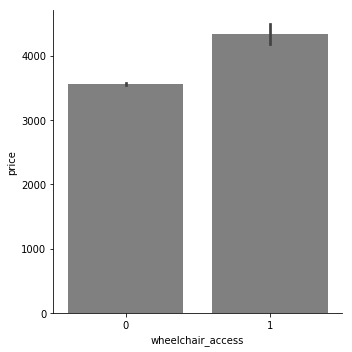

In [0]:
for col in sorted(train.columns):
    if train[col].nunique() < 12:
        sns.catplot(x=col, y='price', data=train, kind='bar', color='grey')
        plt.show()

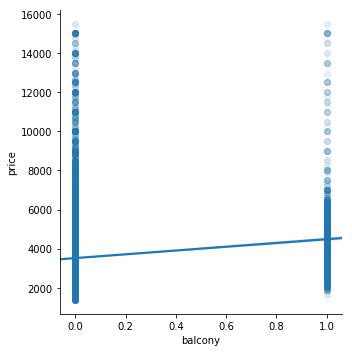

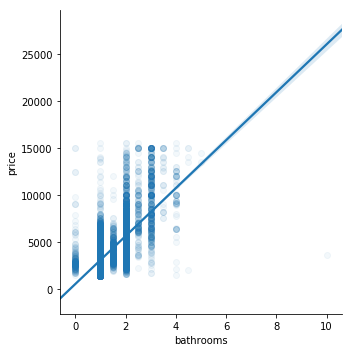

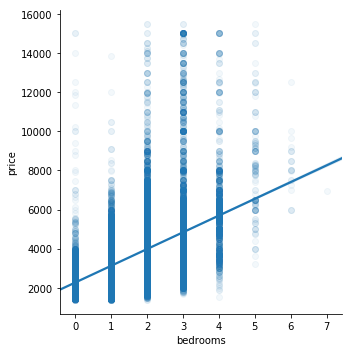

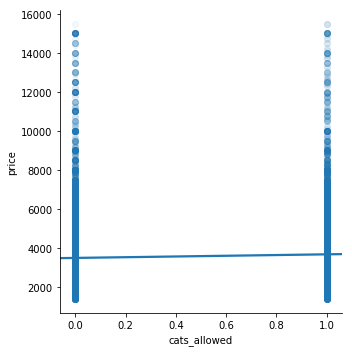

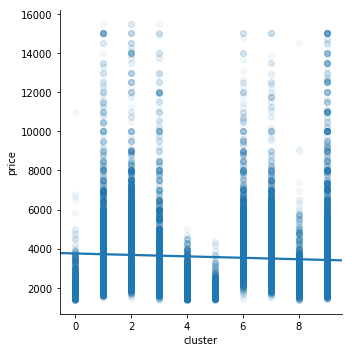

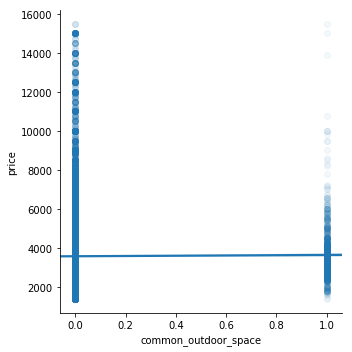

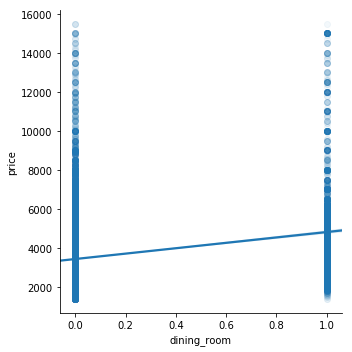

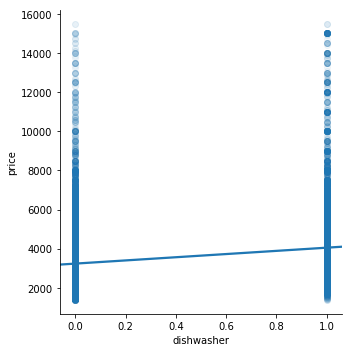

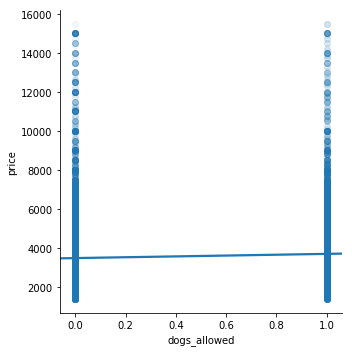

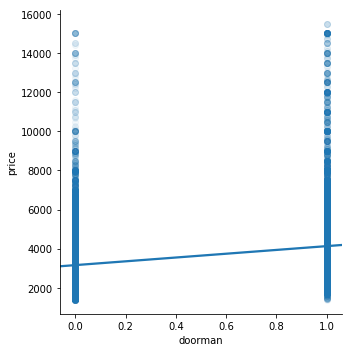

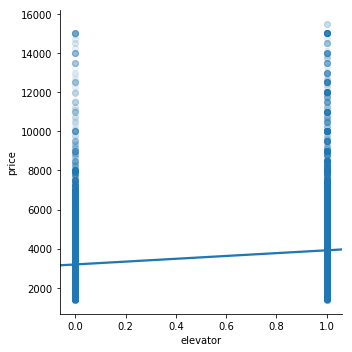

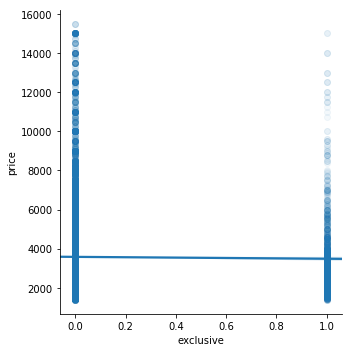

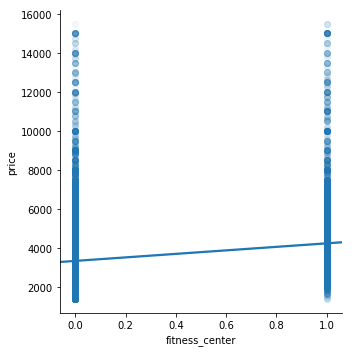

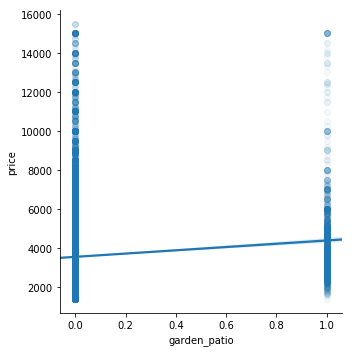

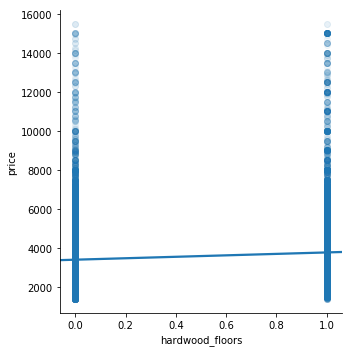

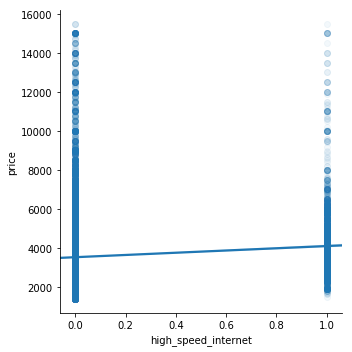

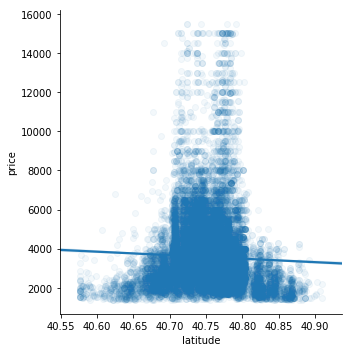

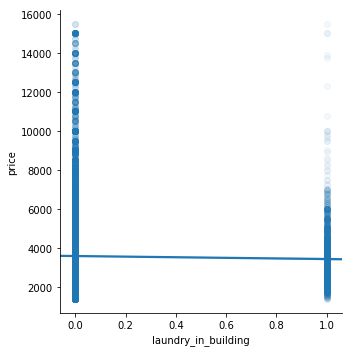

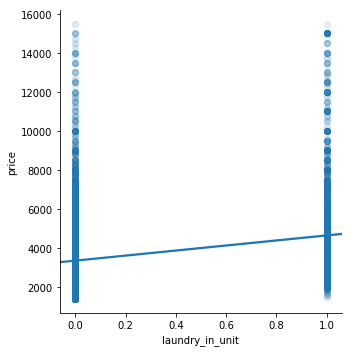

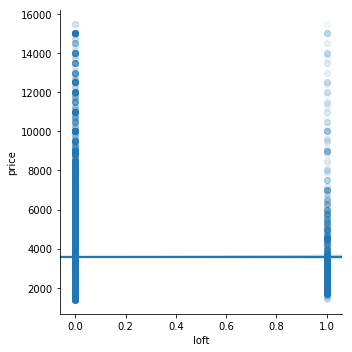

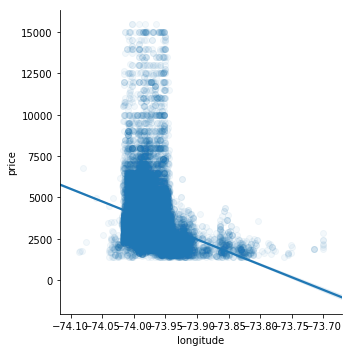

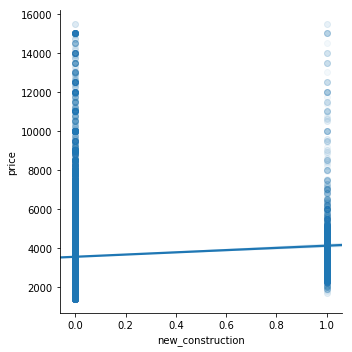

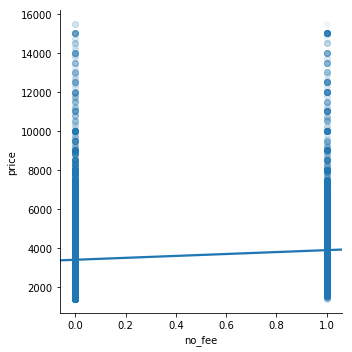

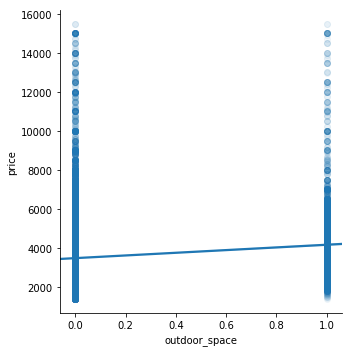

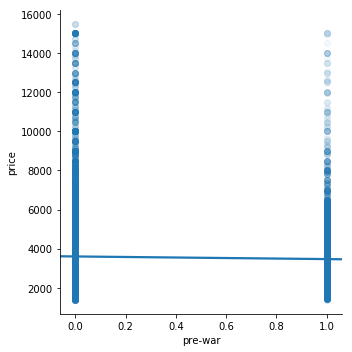

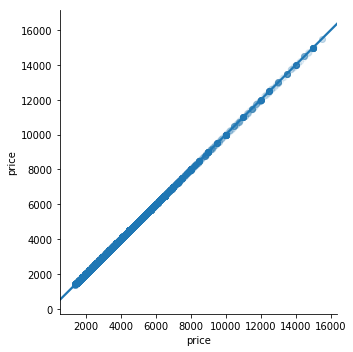

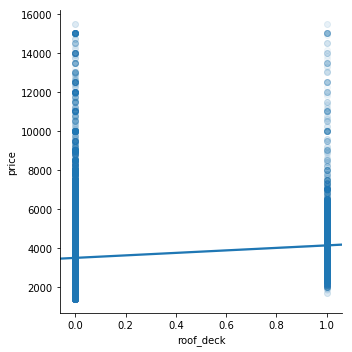

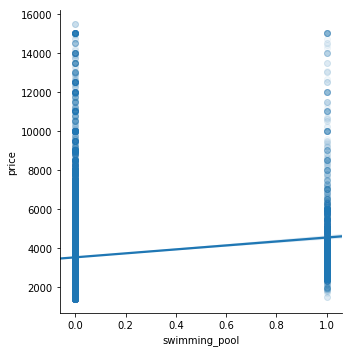

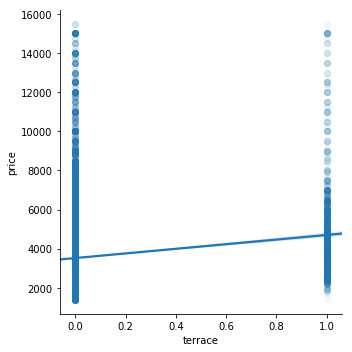

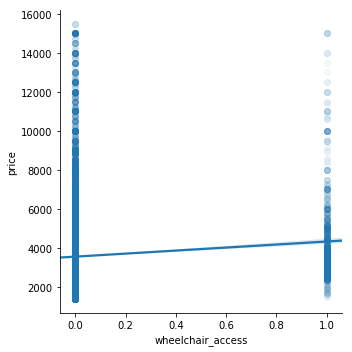

In [0]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='price', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

## Feature Engineering

In [0]:
def engineer_features(df):
    # What's the neighborhood, based on address or latitude & longitude?
    clusters = pd.get_dummies(df['cluster'], prefix='cluster')
    for col in clusters:
        df[col] = clusters[col]
        
    # Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    # How long is the description?
    df['description_length'] = df['description'].str.len()

    # How many total perks does each apartment have?
    perk_cols = ['elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
                 'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
                 'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
                 'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
                 'swimming_pool', 'new_construction', 'exclusive', 'terrace', 
                 'loft', 'garden_patio', 'common_outdoor_space', 
                 'wheelchair_access']
    df['perk_count'] = df[perk_cols].sum(axis=1)

    # Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    # Are cats and dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    # Total number of rooms (beds + baths)
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

    
train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

((31844, 51), (16973, 51))

## Feature Selection

The previous assignment quoted Wikipedia on [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering):

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

Pedro Domingos says, "the most important factor is the **features used**."

This includes not just **Feature Engineering** (making new features, representing features in new ways) but also **Feature Selection** (choosing which features to include and which to exclude).

There are _many_ specific tools and techniques for feature selection.

- Today we'll try [scikit-learn's `SelectKBest` transformer](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), for "univariate, forward selection."
- Next week we'll try another technique, ["permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
- If you want to explore even more options, here are some good resources!
  - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
  - [mlxtend](http://rasbt.github.io/mlxtend/) library
  - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
  - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.


My general recommendation is:

> Predictive accuracy on test sets is the criterion for how good the model is. — Leo Breiman, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)

### Can we try every possible feature combination?
- https://en.wikipedia.org/wiki/Combination
- https://docs.python.org/3/library/itertools.html#itertools.combinations
- https://docs.python.org/3/library/math.html#math.factorial

In [0]:
# How many features do we have currently?
target = 'price'
features = train.columns.drop(target)
len(features)

50

In [0]:
# How many ways to choose 1 feature?
from itertools import combinations
len(list(combinations(features, 1)))

50

In [0]:
# How many ways to choose 2 features?
len(list(combinations(features, 2)))

1225

In [0]:
# How many ways to choose 3 features?
len(list(combinations(features, 3)))

19600

In [0]:
# How many ways to choose 1 to n features?

from math import factorial

def n_choose_k(n, k):
    return factorial(n)/(factorial(k)*factorial(n-k))

total = 0
for k in range(1, len(features)+1):
    total += n_choose_k(len(features), k)
    
print(f'{total:,}')

1,125,899,906,842,623.0


### Start simple & fast, with a subset of columns

Just numeric columns with no missing values

In [0]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 42), (31844,), (16973, 42), (16973,))

### Univariate, Forward selection
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [0]:
# Select the 10 features that best correlate with the target
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before:
# model = LinearRegression()
# model.fit(...)

# IMPORTANT!
# .fit_transfom on the train set
# .transform on test set
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((31844, 10), (16973, 10))

In [0]:
# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
perk_count
rooms

Features not selected:
latitude
elevator
cats_allowed
hardwood_floors
dogs_allowed
no_fee
laundry_in_building
pre-war
roof_deck
outdoor_space
high_speed_internet
balcony
swimming_pool
new_construction
terrace
exclusive
loft
garden_patio
wheelchair_access
common_outdoor_space
cluster
cluster_0
cluster_1
cluster_2
cluster_3
cluster_4
cluster_5
cluster_6
cluster_7
cluster_8
cluster_9
description_length


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $713


In [0]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $890 

2 features
Test MAE: $826 

3 features
Test MAE: $826 

4 features
Test MAE: $800 

5 features
Test MAE: $800 

6 features
Test MAE: $773 

7 features
Test MAE: $713 

8 features
Test MAE: $713 

9 features
Test MAE: $713 

10 features
Test MAE: $713 

11 features
Test MAE: $711 

12 features
Test MAE: $698 

13 features
Test MAE: $698 

14 features
Test MAE: $698 

15 features
Test MAE: $698 

16 features
Test MAE: $697 

17 features
Test MAE: $697 

18 features
Test MAE: $697 

19 features
Test MAE: $683 

20 features
Test MAE: $681 

21 features
Test MAE: $681 

22 features
Test MAE: $674 

23 features
Test MAE: $668 

24 features
Test MAE: $665 

25 features
Test MAE: $665 

26 features
Test MAE: $662 

27 features
Test MAE: $662 

28 features
Test MAE: $662 

29 features
Test MAE: $661 

30 features
Test MAE: $660 

31 features
Test MAE: $658 

32 features
Test MAE: $659 

33 features
Test MAE: $659 

34 features
Test MAE: $659 

35 features
Test MAE: $

## Do one-hot encoding of categorical features

### Which features are non-numeric?

In [0]:
train.describe(exclude='number')

,created,description,display_address,street_address,interest_level,has_description,cats_or_dogs,cats_and_dogs
count,31844,31844,31775,31838,31844,31844,31844,31844
unique,31436,25710,6468,11280,3,2,2,2
top,2016-05-14 01:11:03,,Broadway,505 West 37th Street,low,True,False,False
freq,3,2033,273,120,22053,29811,16627,17669
first,2016-04-01 22:12:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-05-31 23:10:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Notice that fitness center was a numeric encoding of a categorical feature
train['fitness_center'].value_counts()

0    23323
1     8521
Name: fitness_center, dtype: int64

In [0]:
binary_columns = ['has_description', 'cats_or_dogs', 'cats_and_dogs']
for col in binary_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

In [0]:
train[binary_columns].describe()

,has_description,cats_or_dogs,cats_and_dogs
count,31844.000000,31844.000000,31844.000000
mean,0.936158,0.477861,0.445139
std,0.244476,0.499517,0.496989
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


### Check "cardinality" of non-numeric features

[Cardinality](https://simple.wikipedia.org/wiki/Cardinality) means the number of unique values that a feature has:
> In mathematics, the cardinality of a set means the number of its elements. For example, the set A = {2, 4, 6} contains 3 elements, and therefore A has a cardinality of 3. 

"One-hot encoding" adds a dimension for each unique value of each categorical feature. So, it may not be a good choice for "high cardinality" categoricals that have dozens, hundreds, or thousands of unique values. 

In [0]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
interest_level,31844,3,low,22053,NaN,NaN
display_address,31775,6468,Broadway,273,NaN,NaN
street_address,31838,11280,505 West 37th Street,120,NaN,NaN
description,31844,25710,,2033,NaN,NaN
created,31844,31436,2016-05-14 01:11:03,3,2016-04-01 22:12:41,2016-05-31 23:10:48


In [0]:
df['display_address'].value_counts()

### Explore `interest_level` feature

In [0]:
train['interest_level'].value_counts(normalize=True)

low       0.692532
medium    0.231786
high      0.075681
Name: interest_level, dtype: float64

In [0]:
train.groupby('interest_level')['price'].mean()

interest_level
high      2728.689212
low       3802.227633
medium    3175.026013
Name: price, dtype: float64

In [0]:
# Look at interest level for first 5 apartments
train['interest_level'].head()

0      high
1       low
2       low
3    medium
4       low
Name: interest_level, dtype: object

### Encode `interest_level` feature

In [0]:
# Look at interest level for first 5 apartments, one-hot encoded
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['interest_level'])
encoded.head()

,interest_level_high,interest_level_low,interest_level_medium
0,1,0,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0


## Do one-hot encoding & Scale features, 
within a complete model fitting workflow.

### Why and how to scale features before fitting linear models

Scikit-Learn User Guide, [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

> The `preprocessing` module further provides a utility class `StandardScaler` that implements the `Transformer` API to compute the mean and standard deviation on a training set. The scaler instance can then be used on new data to transform it the same way it did on the training set.

### How to use encoders and scalers in scikit-learn
- Use the **`fit_transform`** method on the **train** set
- Use the **`transform`** method on the **validation / test** sets

In [0]:
from sklearn.preprocessing import StandardScaler

target = 'price'
high_cardinality = ['display_address', 'street_address', 'description', 'created']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $890 

2 features
Test MAE: $826 

3 features
Test MAE: $826 

4 features
Test MAE: $800 

5 features
Test MAE: $800 

6 features
Test MAE: $773 

7 features
Test MAE: $713 

8 features
Test MAE: $714 

9 features
Test MAE: $714 

10 features
Test MAE: $713 

11 features
Test MAE: $711 

12 features
Test MAE: $684 

13 features
Test MAE: $673 

14 features
Test MAE: $673 

15 features
Test MAE: $672 

16 features
Test MAE: $671 

17 features
Test MAE: $671 

18 features
Test MAE: $671 

19 features
Test MAE: $671 

20 features
Test MAE: $671 

21 features
Test MAE: $656 

22 features
Test MAE: $656 

23 features
Test MAE: $654 

24 features
Test MAE: $654 

25 features
Test MAE: $648 

26 features
Test MAE: $643 

27 features
Test MAE: $641 

28 features
Test MAE: $641 

29 features
Test MAE: $640 

30 features
Test MAE: $640 

31 features
Test MAE: $639 

32 features
Test MAE: $638 

33 features
Test MAE: $636 

34 features
Test MAE: $636 

35 features
Test MAE: $